# Region DS

In [1]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from gradientVersion import *
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");

In [38]:
expression_donors_ds5 = get_expression_abagen(fetch_hcp(), DS_threshold=0.5, donors_threshold=3, return_donors=True)
expression_donors_ds9 = get_expression_abagen(fetch_hcp(), DS_threshold=0.9, donors_threshold=2, return_donors=True)

7973 genes remain after filtering for top 0.5 differential stability
1595 genes remain after filtering for top 0.1 differential stability


In [39]:
from itertools import combinations

def get_region_ds(expression_donors):
    region_corrs = {}
    
    for x,y in combinations(range(6), 2):
        X = expression_donors[x]
        Y = expression_donors[y]

        name=f'{x}{y}'
        region_corrs[name] = X.T.corrwith(Y.T)
    
    region_ds = pd.concat(region_corrs, axis=1).mean(axis=1)[:180]
    
    return region_ds

In [71]:
region_ds_dict = {
    '2+ DS9': get_region_ds(expression_donors_ds9),
    '3+ DS5': get_region_ds(expression_donors_ds5)
}

region_ds = (
    pd.concat(region_ds_dict, axis=1)
    .apply(lambda x: (x-np.mean(x))/np.std(x))
    .join(get_labels_hcp())
)

region_ds_plot = region_ds.melt(id_vars='label', var_name='version', value_name='Region DS').dropna()

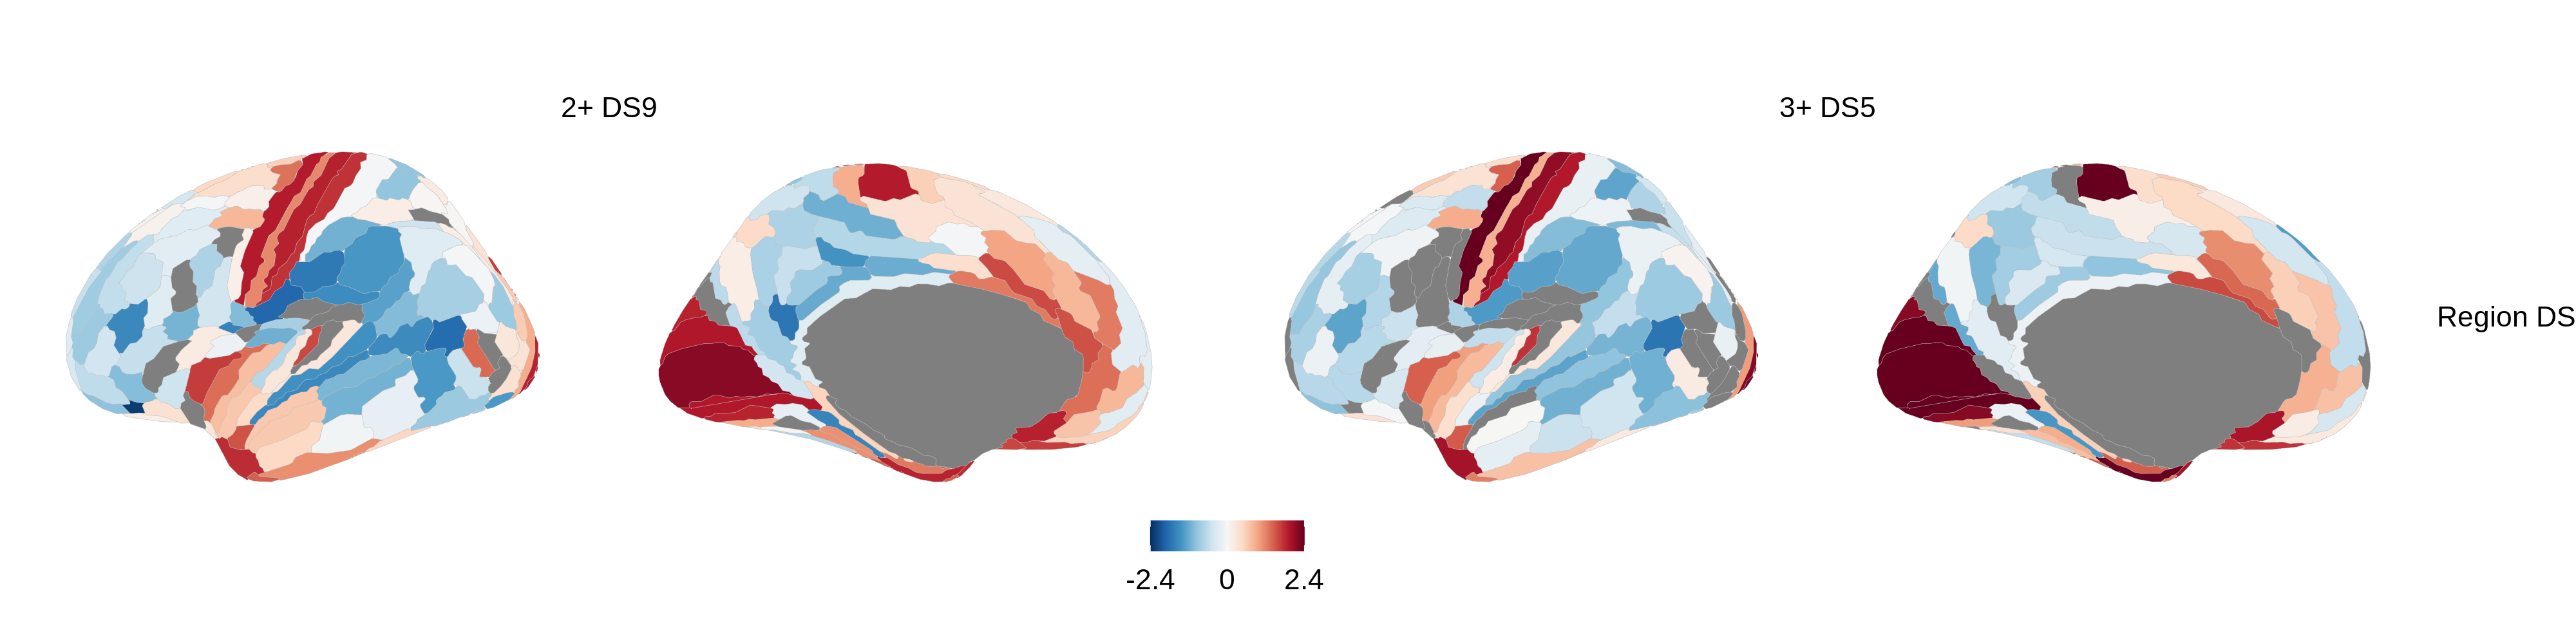

In [73]:
%%R -w 20 -h 5 --units in -r 200 -i region_ds_plot
plot_hcp(region_ds_plot, facet='h') & theme(text=element_text(size=20))

In [80]:
# dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [74]:
dm_hcp_ds9.clean_scores().set_index('label').join(region_ds.set_index('label')).corr(method='spearman').iloc[:3,3:]

,2+ DS9,3+ DS5
G1,-0.091922,-0.177147
G2,-0.487423,-0.430125
G3,0.553725,0.547604


In [65]:
dm_hcp_ds9.clean_scores().set_index('label').join(region_ds.set_index('label')).corr().iloc[:3,3:]

,3+ DS5,2+ DS9
G1,-0.121332,-0.090481
G2,-0.506838,-0.492769
G3,0.586764,0.572138


In [87]:
def make_scatter(version, region_ds_version):
    out = (
        version.clean_scores().set_index('label')
        .join(region_ds.set_index('label'))
        .loc[:,['G3', region_ds_version]]
        .rename({region_ds_version:'region_ds'},axis=1)
    )
    return out

region_ds_scatter = {
    'DS9': make_scatter(dm_hcp_ds9, '2+ DS9'),
    '3+ DS5': make_scatter(dm_hcp_ds9, '3+ DS5')
}

region_ds_scatter = (
    pd.concat(region_ds_scatter)
    .reset_index(0).rename({'level_0':'version'},axis=1)
)
region_ds_scatter

,version,G3,region_ds
label,,,
V1,DS9,1.489917,2.186290
MST,DS9,0.843116,1.371512
V6,DS9,0.225048,NaN
V2,DS9,1.128047,1.925356
V3,DS9,0.851361,1.855312
...,...,...,...
STSva,3+ DS5,-0.975472,-0.008529
TE1m,3+ DS5,-1.215249,-0.522566
PI,3+ DS5,-0.284320,0.381818


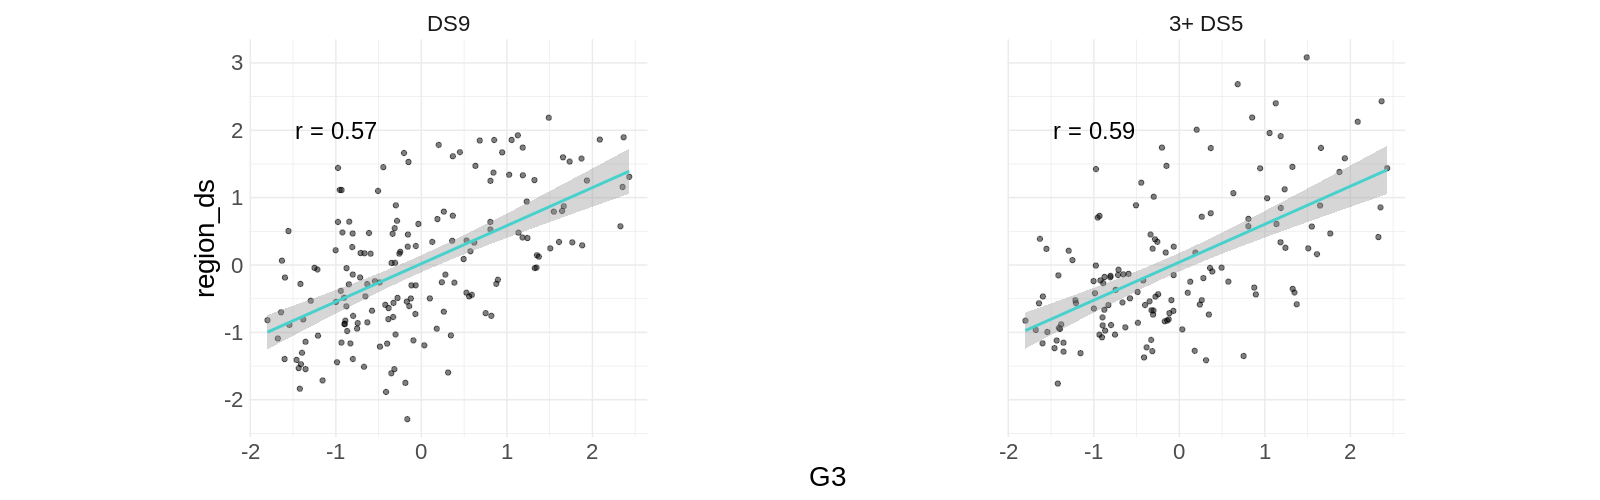

In [107]:
%%R -w 16 -h 5 --units in -r 100 -i region_ds_scatter
corrs <- region_ds_scatter %>%
    group_by(version) %>% summarize(cor(G3, region_ds, use='p')) %>%
    mutate(version = factor(version, ordered=T, levels=unique(.$version)))
names(corrs) <- c('version', 'r')

region_ds_scatter %>%
mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
ggplot(aes(x=G3, y=region_ds)) +
facet_wrap(~version) +
geom_point(alpha=.5) +
geom_smooth(color='mediumturquoise', method='lm') +
geom_text(data=corrs, x=-1, y=2, aes(label=paste('r =', round(r, 2))), size=6) +
theme_minimal() +
theme(aspect.ratio=1, text=element_text(size=20), panel.spacing=unit(18, 'lines'))